# Makine Öğrenimi Uygulaması: ENRON Suçlu Bulucu

Bu çalışmanın amacı makine öğrenimi sürecinde konseptlerin anlaşılması amacıyla gerçek dünyadan gerçek verilerin kullanıldığı bir uygulama örneği sunmaktır. Uygulama aynı zamanda Udacity - "Intro to Machine Learning" dersinin final projesidir. Projenin amacı basit bir ifadeyle, üst düzey yöneticilerin eposta ve mali durum bilgilerini içeren Enron veri setinin makineye öğretilerek bir kişinin suçlu olup olmadığının tahminini yapan bir modellemenin geliştirilmesidir. Python 2 programlama dilinde yazılan projede; veri analizi, işleme ve görselleştirmede Numpy, Pandas, matplotlib, seaborn kütüphaneleri, makine öğrenimi için scikit-learn kütüphanesi kullanılmıştır. Çalışmanın anlaşılabilmesi betimsel ve kestirimsel istatistik ile yeterli seviye Python programlama dili bilgisi gerektirmektedir. Öncelikle belirtilen internet adresinden indirdiğimiz, veri setini ve proje boyunca kullanacağımız yardımcı kod dosyalarını barındıran dosyayı Python'a tanıtıyoruz. Proje süresince yararlanacağımız ilgili Python kütüphanelerini "import" ettikten sonra veri setini içeren "final_project_dataset.pkl" adlı veri dosyasını üzerinde çalışmaya başlamak için okutuyoruz. 

In [1]:
import os
os.chdir('/home/tuna/PycharmProjects/IntroMachineLearning/ud120-projects/final_project/')
import sys
sys.path.append("../tools/")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from feature_format import featureFormat
from feature_format import targetFeatureSplit
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing
from tester import test_classifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

/home/tuna/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
ayirac = '-----------------------------------------------------------------------------------------------------------'

## Veri setini anlama

Her analizin başlangıcında olduğu gibi veri setine dair temel bilgileri edinerek başlıyoruz, buna göre veri setinde "dictionary" formatında 146 veri noktası bulunmaktadır. Bu veri noktalarının her biri Enron'un üst düzey yetkililerini temsil etmektedir. İlk veri noktasının anahtar(key) ve değerlerine(values) baktığımızda anahtarın kişinin soyadı ve adı, değerlerin bu kişiye ait toplamda 21 özellikten(features) oluşan eposta ve mali bilgileri olduğu görülmektedir. İlerleyen aşamalarda analize tabi tutulacak yeni özellik çıkarımları yapabilmek için en başında bu özelliklerin neler olduğunu incelemenin ve yorumlamanın faydası olacaktır. İlgili özelliklere baktığımızda bir önceki blog gönderimde de bahsettiğim üzere özellikler eposta, mali durum bilgileri ve kişinin suçlu olup olmadığını gösteren üç ana başlık altında toplanmaktadır.(Bu noktadan itibaren suçlu kişiler veri setinde olduğu gibi "POI" olarak geçecektir.)  Eposta özelliklerini incelersek;
'to_messages'            : İlgili kişiye gelen e-posta sayısı
'from_messages'          : İlgili kişinin gönderdiği e-posta sayısı 
'from_this_person_to_poi': İlgili kişiden POI'ye gönderilen eposta sayısı
'from_poi_to_this_person': POI'den ilgili kişiye gönderilen eposta sayısı
'shared_receipt_with_poi': İlgili kişinin POI ile birlikte gönderim listesinde yer aldığı eposta sayısı
'email_address'          : İlgili kişinin eposta adresini ifade etmektedir.
Tamamı Amerikan doları cinsinden mali durum bilgilierini gösteren özellikler incelendiğinde ilgili kişinin maaş, bonus, vadeli ödeme gibi ödemelerle('salary','deferral_payments','total_payments', 'bonus', 'expenses', 'loan_advances', 'director_fees', 'deferred_income', 'long_term_incentives') birlikte şirket hisse senetleriyle('exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value') ilgili özellikler bulunmaktadır. Veri dosyasının içinde yer alan pdf formatındaki mali tablo incelendiğinde görülecektir ki 
'total_payments'; 'salary','deferral_payments','total_payments', 'bonus', 'expenses', 'loan_advances', 'director_fees',  'long_term_incentives' değerlerinin toplamından 'deferred_income' değerinin çıkarılmasıyla elde edilmiştir. Aynı şekilde, 'total_stock_value'; 'exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred' değerlerinin toplamına eşittir. Bunu fark etmemiz, birbiriyle yüksek korelasyona sahip özellikleri belirleyerek analiz esnasında uygulayacağımız yönteme veya algoritmaya göre onları dışarıda tutmak veya dahil etme seçeneğini elde tutmaktır.  

In [4]:
print type(data_dict)
print "Enron veri setindeki veri noktalarının:", len(data_dict)

<type 'dict'>
Enron veri setindeki veri noktalarının: 146


In [5]:
print "Her bir kişi için özellik sayısı:", len(data_dict[data_dict.keys()[0]])

Her bir kişi için özellik sayısı: 21


In [6]:
print data_dict.keys()[0]

METTS MARK


In [7]:
print data_dict.values()[0]

{'salary': 365788, 'to_messages': 807, 'deferral_payments': 'NaN', 'total_payments': 1061827, 'exercised_stock_options': 'NaN', 'bonus': 600000, 'restricted_stock': 585062, 'shared_receipt_with_poi': 702, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 585062, 'expenses': 94299, 'loan_advances': 'NaN', 'from_messages': 29, 'other': 1740, 'from_this_person_to_poi': 1, 'poi': False, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 'NaN', 'email_address': 'mark.metts@enron.com', 'from_poi_to_this_person': 38}


Veri setinde yer alan 146 Enron üst düzey yöneticisinden kaçının "POI"(Person of Interest) olduğunu belirliyoruz. Buna göre 146 kişiden 18'i POI'dir. "POI" ne demek tekrar hatırlamak gerekirse; haklarında dava açılmış, hukuki uzlaşıya varılmış, devlet ile itiraf anlaşması yapmış veya savcı dokunulmazlığı karşılığında tanıklık etmiş, kısaca skandala yol açan dolandırıcılığa karışmış kişilerdir. Elbette gerçekte Enron skandalına karışan POI sayısı daha fazla, buradaki 18 değeri proje amaçlı oluşturulmuş veri setinde yer alan POI'leri yansıtmaktadır.  

In [8]:
count_poi = 0
count_nonpoi = 0
for person in data_dict:
    if data_dict[person]['poi']:
        count_poi += 1
    else:
        count_nonpoi += 1
print "POI sayısı:", count_poi
print "POI olmayanların sayısı:", count_nonpoi

POI sayısı: 18
POI olmayanların sayısı: 128


Veri setini araştırmada dikkat çeken bir husus da 'NaN' değerleri. Halihazırda gelen verisetindeki bu değerler ilk bakışta eksik/olmayan değerleri ifade etse de Numpy formatında 'NaN' olmadığı için makine bunları da bir değer olarak algılayıp tüm veri setinde hiçbir eksik veri yokmuş gibi görmektedir. Bu durumu düzeltmek için NaN değerlerini Numpy formatında 'NaN'a dönüştürerek her bir özellik için var olan değerlerin sayısını görüntülüyoruz. Çok az veriye sahip özelliklerin belirlenmesi, oluşturacağımız modele olumsuz etki gösterme ihtimali nedeniyle duruma göre analiz dışı tutmamız açısından önemli. 

In [9]:
# Pandas .info() ile veri setine ait genel bilgiler
enron_data = pd.DataFrame.from_dict(data_dict, orient = 'index')
enron_data.replace('NaN', np.nan, inplace = True)
enron_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       95 non-null float64
to_messages                  86 non-null float64
deferral_payments            39 non-null float64
total_payments               125 non-null float64
exercised_stock_options      102 non-null float64
bonus                        82 non-null float64
restricted_stock             110 non-null float64
shared_receipt_with_poi      86 non-null float64
restricted_stock_deferred    18 non-null float64
total_stock_value            126 non-null float64
expenses                     95 non-null float64
loan_advances                4 non-null float64
from_messages                86 non-null float64
other                        93 non-null float64
from_this_person_to_poi      86 non-null float64
poi                          146 non-null bool
director_fees                17 non-null float64
deferred_income              49 non-null float

Veri setimiz binlerce veya onbinlerce satır ve sütundan oluşmadığından tamamını görüntüleyip bir göz atmanın yararı olacaktır. Bir önceki kod hücresinde görüleceği üzere veri yapıları için uygun bir kütüphane olan Pandas'ı kullandım. Python sözlüğü(dictionary) türündeki veriyi Pandas'ı kullanarak 'enron_data' olarak adlandırdığım bir DataFrame'e dönüştürdüm. İnceleme sonucunda dikkatimi, kişi adları arasında bir kişiye ait olmadığı anlaşılan 'THE TRAVEL AGENCY IN THE PARK' çekti. Kısa bir araştırma sonucunda bu verinin Enron yönetim kurulu başkanı Kenneth Lay'in kız kardeşine ait şirkete ait olduğunu, Enron'un şirket çapında yaptığı gezilerin organizasyonu için bu şirkete ödeme yaptığını öğrendim. Bu veri noktasını bir kişiyi temsil etmediği için bir sonraki bölüm olan aykırı verilerin tespitinde veri setinden çıkardım. Ancak ifade etmek gerekir ki, hukuki davalarda işletmelerin de bir "kişi" olarak görülebildiği durumlarda bu veri noktasının kalması tercih edilirdi. Bir veri noktasının veri setinden çıkarılması karşılaşılan durumun, problemin türüne göre, özelliğine göre değişir. Fark edilen bir diğer veri noktası da 'LOCKHART EUGENE E'dir. Bu kişiye ait hiçbir veri bulunmasa da veri setinde yer almıştır, herhangi bir etkiye sahip olmadığı için o da veri setinden çıkarılmıştır.     

In [10]:
# Veri setinin Pandas ile 'DataFrame' tablo şeklinde gösterimi
#pd.options.display.max_rows = 150
# Blog gönderisinde ilk 10 satır gösterilmiştir.
enron_data.head(10)

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,...,NaN,2195.0,152.0,65.0,False,NaN,-3081055.0,304805.0,phillip.allen@enron.com,47.0
BADUM JAMES P,NaN,NaN,178980.0,182466.0,257817.0,NaN,NaN,NaN,NaN,257817.0,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477.0,566.0,NaN,916197.0,4046157.0,NaN,1757552.0,465.0,-560222.0,5243487.0,...,NaN,29.0,864523.0,0.0,False,NaN,-5104.0,NaN,james.bannantine@enron.com,39.0
BAXTER JOHN C,267102.0,NaN,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,NaN,NaN,10623258.0,...,NaN,NaN,2660303.0,NaN,False,NaN,-1386055.0,1586055.0,NaN,NaN
BAY FRANKLIN R,239671.0,NaN,260455.0,827696.0,NaN,400000.0,145796.0,NaN,-82782.0,63014.0,...,NaN,NaN,69.0,NaN,False,NaN,-201641.0,NaN,frank.bay@enron.com,NaN
BAZELIDES PHILIP J,80818.0,NaN,684694.0,860136.0,1599641.0,NaN,NaN,NaN,NaN,1599641.0,...,NaN,NaN,874.0,NaN,False,NaN,NaN,93750.0,NaN,NaN
BECK SALLY W,231330.0,7315.0,NaN,969068.0,NaN,700000.0,126027.0,2639.0,NaN,126027.0,...,NaN,4343.0,566.0,386.0,False,NaN,NaN,NaN,sally.beck@enron.com,144.0
BELDEN TIMOTHY N,213999.0,7991.0,2144013.0,5501630.0,953136.0,5249999.0,157569.0,5521.0,NaN,1110705.0,...,NaN,484.0,210698.0,108.0,True,NaN,-2334434.0,NaN,tim.belden@enron.com,228.0
BELFER ROBERT,NaN,NaN,-102500.0,102500.0,3285.0,NaN,NaN,NaN,44093.0,-44093.0,...,NaN,NaN,NaN,NaN,False,3285.0,NaN,NaN,NaN,NaN
BERBERIAN DAVID,216582.0,NaN,NaN,228474.0,1624396.0,NaN,869220.0,NaN,NaN,2493616.0,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,david.berberian@enron.com,NaN


## Aykırı verilerin yakalanması

Diğer değerlerle karşılaştırıldığında veri setine uygun olmadığı belirlenen aşırı değerlere sahip aykırı veriler (outliers), yapacağımız istatistiksel analizlerde ve modellemelerde olumsuz etkiye sebep olacağından bu değerlerin tespit edilerek veri setinden ayıklanması önceliklidir. Aykırı verilere sebep olan nedenler arasında verinin toplanma türüne göre alıcı/sensör bozuklukları, veri girişinde yapılan hatalar zaman zaman göz ardı veya tolere edilebilirken; uçuk ve anormal durumlara mutlaka dikkat edilmeli ve sebepleri araştırılmalıdır. Veri setimizde aykırı verilerin tespitinde makine öğreniminin önemli araçlarından biri olan korelasyonu kullanacağız. Buna göre herhangi iki nitelik arasındaki ilişkiyi görselleştirerek varsa aykırı değeri belirleyeceğiz. Ders içindeki uygulamada olduğu gibi 'salary' ve 'feature' niteliklerini seçtim.

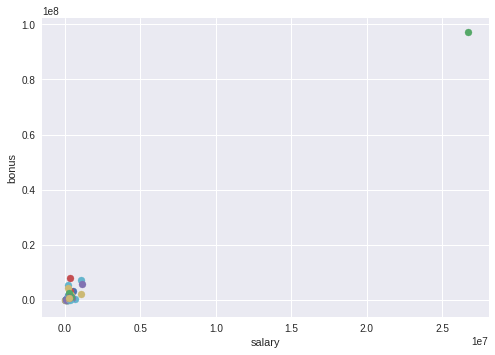

In [11]:
# Seçilen iki özelliğin görselleştirilmesi
features = ['salary', 'bonus']
data = featureFormat(data_dict, features)

for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter(salary, bonus)
    
plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

Grafikte görüldüğü üzere değerlerin çoğunluğu sol altta birikirken, tek bir değer grafiğin sağ üst köşesinde yer almaktadır. Anormal bir durum olduğu aşikar. Bu değeri alt hücrede yer alan kodlarla belirlediğimizde, verinin 'TOTAL'e ait olduğu anlaşılmıştır. Bu demek oluyor ki, veri setinde yer alan tüm kişilere ait özelliklerin değerleri toplamı da veri setine dahildir. Dolayısıyla analiz ve modellemelerde olumsuz etki yaratacağından 'TOTAL', veri setinden çıkarılmıştır. Aynı zamanda, daha önce bahsedildiği üzere hiçbir değere sahip olmayan 'LOCKHART EUGENE E', herhangi bir etki yaratmayacağından bu aşamada veri setinden çıkarılmıştır.  

In [12]:
# En yüksek 'salary' değerinin bulunması
salary = []
for k in data_dict:
    if data_dict[k]['salary'] != 'NaN':
        salary.append(data_dict[k]['salary'])
for k in data_dict:
    if data_dict[k]['salary'] == max(salary):
        print k

TOTAL


In [13]:
# Belirlenen aykırı ve diğer verilerin veri setinden çıkarılması
data_dict.pop('THE TRAVEL AGENCY IN THE PARK', 0)
data_dict.pop('LOCKHART EUGENE E', 0)
data_dict.pop('TOTAL', 0)

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

Tespit edilen aykırı değer 'TOTAL'in veri setinden çıkarılması sonrasında 'salary' ve 'bonus' niteliklerimizi bu işlem sonrası tekrar görselleştirdiğimizde veri noktaları yoğunluğunun dışındaki bazı değerler dikkat çekiyor. Bu değerlerin kime ait olduğunu öğrenmek için 'salary', yani maaş miktarlarına göre en yüksek 4 değeri ve 'bonus' miktarlarına göre en yüksek 3 değeri sıraladığımızda, ikisinde de 'SKILLING JEFFREY K' ve 'LAY KENNETH L'e ait değerler olduğunu saptıyoruz. Görsele ilk bakışta hem X hem de Y ekseninde bu iki değer uç noktalarda gözükse de bu değerlere sahip iki isim Enron'un CEO'su ve yönetim kurulu başkanı olarak skandalın kilit isimleri olması nedeniyle araştırmamızda önem arz ediyor. Çünkü Jeffrey Skilling ve Kenneth Lay'i analizin dışında tutmak tüm Enron hikayesini değiştirmek anlamına gelir. Veri setinde aykırı değer tespitini tamamlayarak bir sonraki aşama olan özellik(feature) seçimine geçiyoruz.

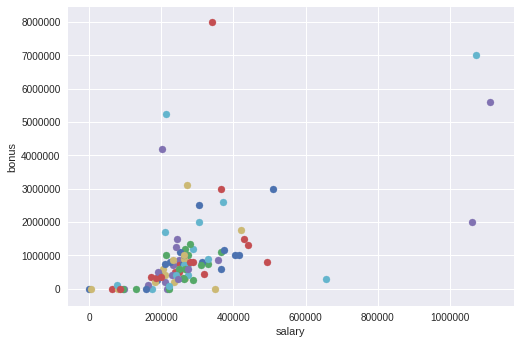

In [14]:
# Aykırı veri ve belirlenen iki özel veri noktasının çıkarılması sonrası görselleştirme 
features = ['salary', 'bonus']
data = featureFormat(data_dict, features)
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter(salary, bonus)
    
plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

In [15]:
# Görsele göre en yüksek 'salary' değerlerinin kimlere ait olduğunun bulunması
max4_salary = []
for person in data_dict:
    amount = data_dict[person]['salary']
    if amount == 'NaN':
        continue
    max4_salary.append((person, int(amount)))

max4_salary = (sorted(max4_salary,key=lambda x:x[1],reverse=True)[:4])
max4_salary

[('SKILLING JEFFREY K', 1111258),
 ('LAY KENNETH L', 1072321),
 ('FREVERT MARK A', 1060932),
 ('PICKERING MARK R', 655037)]

In [16]:
#Görsele göre en yüksek 'bonus' değerlerinin kimlere ait olduğunun bulunması
max3_bonus = []
for person in data_dict:
    amount = data_dict[person]['bonus']
    if amount == 'NaN':
        continue
    max3_bonus.append((person, int(amount)))

max3_bonus = (sorted(max3_bonus,key=lambda x:x[1],reverse=True)[:3])
max3_bonus

[('LAVORATO JOHN J', 8000000),
 ('LAY KENNETH L', 7000000),
 ('SKILLING JEFFREY K', 5600000)]

### Yeni özellik oluşturulması

Eldeki özellikleri seçime tabi tutmadan önce -proje görevi olması nedeniyle de- yeni özellik yaratmaya çalışacağım. Bunda amaç var olan özellikleri kullanarak kendi sezgimizle yarattığımız, modellememizde doğruluk, tahmin oranlarında daha iyi sonuçlar almayı sağlayacak yeni özellikleri analize dahil etmek. Açıkçası yeni özellik oluşturulmasında Udacity'deki ders içeriğine bağlı kaldım ve eposta özellikleri üzerinden yeni bir özellik yaratmayı tercih ettim. Kişinin, POI'lerden aldığı('from_poi_to_this_person'), POI'lere gönderdiği('from_this_person_to_poi'), POI'ler ile aynı gönderim listesinde yer aldığı('shared_receipt_with_poi') eposta sayısı toplamının kişinin toplam eposta yazışmaları sayısına('from_messages'+'to_messages') oranını veren, oluşturduğum bu özelliğe 'poi_mailing_factor' adını verdim. 'poi_mailing_factor' özelliğini yaratmada; eğer bir kişi POI ise, tüm eposta yazışmaları içinde, diğer POI'ler ile eposta yazışmaları sayısının POI olmayan bir kişininkine göre daha fazla olacağı önsezisiyle, bu değerin POI kişilerde daha yüksek olacağını varsayarak POI bulucu modelimizde ayırt edici bir özellik olacağını düşündüm.   

In [17]:
# Yeni özellik oluşturulması
for person in data_dict:
        
        try:
            total_messages = data_dict[person]['from_messages'] + data_dict[person]['to_messages']
            from_poi = data_dict[person]["from_poi_to_this_person"]
            to_poi =  data_dict[person]["from_this_person_to_poi"]
            shared_poi = data_dict[person]["shared_receipt_with_poi"]
            
            poi_involved_messages = from_poi + to_poi + shared_poi 
            #convert data types to float
            total_messages = float(total_messages)
            from_poi = float(from_poi)
            to_poi = float(to_poi)
            shared_poi = float(shared_poi)
            

            poi_mailing_factor = poi_involved_messages / total_messages
            data_dict[person]['poi_mailing_factor'] = poi_mailing_factor

        except:
            data_dict[person]['poi_mailing_factor'] = 'NaN'

Yeni özelliğin oluşturulması sonrasında, aykırı değerlerden temizlenmiş 'data_dict' adlı veri setinin son halini 'my_dataset' adına eşitledim. Oluşturulan yeni özelliğin de eklenmesiyle veri setindeki özelliklerden 'features_list' adında özellik listesi oluşturdum. Mevcut özellikler arasında 'email_address' hem diğer özellikler sayısal iken metin (string) türünde olduğundan, hem de modelleme sürecinde herhangi bir etkiye sahip olmayacağından analize tabi tutulacak özellik listesinden çıkarttım. Bu noktada, 'feature_list' in oluşturulmasında önemli husus; bir kişinin POI olup olmadığı bilgisini veren 'poi'nin, hedef özelliğimiz olduğu için listenin başına yerleştirilmesidir.  

In [18]:
my_dataset = data_dict

In [19]:
for key in data_dict:
    f = data_dict[key].keys()
f.remove('email_address')
f.remove('poi')
f.insert(0, 'poi')
features_list = f

In [20]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

Buraya kadar yaptığımız işlemlerle birlikte veri setimiz makine öğrenimi için hazır bir aşamaya geldi. Bundan sonra yapacaklarımız, en iyi değerlendirme metriklerine sahip modellemenin oluşturulması için makineye sahip olduğumuz verilerin öğretilmesinde en uygun algoritma ve parametrelerin seçilmesi olacak. Her ne kadar bunu en uygun yöntemin seçilmesi olarak tek cümlede ifade etsek de, bu süreç de içerisinde birden fazla uygunluğun arayışını barındıracak. Bu blog gönderisi makine öğrenimine ilgi duyanlara, yeni başlayanlara konseptlerin anlaşılması için bir uygulama örneği olduğu için uygun algoritma ve parametrelerin bulunmasını sağlayan kısayolların direkt anlatımı yerine, aşama aşama, çalıştır-değerlendir-değiştir yaparak, en iyi değerlendirme metriklerine sahip modellemenin oluşturulması sürecinin nasıl şekillendiğini ortaya koymaya çalışacağım. 

# Özellik seçimi

Özellik seçiminde amacımız bir kişinin POI olup olmadığını belirlemede etkisiz veya olumsuz etkiye sahip özelliklerin (features) belirlenerek analiz dışında tutulmasıdır. Modellememizde yer almasını istemeyeceğimiz özellikler,  aşırı uyuma (overfitting) neden olan, hedef niteliğimiz olan 'poi' ile yüksek korelasyonlu değerlere sahip olabileceği gibi, düşük korelasyonlu, 'train/test' sürecini yavaşlatacak etkisiz özellikler de olabilir. Algoritma seçimi öncesinde algoritmaya dahil edilecek özelliklerin seçimi, algoritmanın değerlendirme metriklerini değiştiren ana etkenlerden biri olması nedeniyle önem arz etmektedir. Özellik seçiminde amacımız; ölçülebilir değerlerden oluşan çok sayıda özelliğin içinde en çok bilgiyi barındıran saklı özelliklerin ortaya çıkarılması ve böylece belirlenen salt bu özelliklerin algoritmaya dahil edilmesiyle modellememizin başarım ölçütlerinin artırılmasıdır.

### SelectKBest

Uygulamamızda, ön işleme sonrası ('email_address'in çıkarılması, 'poi_mailing_factor'un eklenmesi sonrası) veri setinde hedef özelliğimiz 'poi' dahil toplam 21 nitelik bulunmakta. Özellik sayısının fazla olmaması nedeniyle sezgisel olarak kendimizin bu özellikleri elle seçebilmesi mümkün bir seçenek olarak görünse de, hangi özelliklerin kaçının birlikte algoritmaya dahil edilmesi yüzlerce kombinasyonun denenmesini gerektireceğinden elle seçim tercihini saf dışı bıraktım. Scikit-learn'ün mahareti işte bu aşamada devreye giriyor, özellik seçimi araçlarından (sklearn.feature_selection) SelectKBest, problemimizde tek değişkenli istatistik testlerine dayanarak hedef özellik('poi') ile ilişkili en iyi özellikleri belirliyor (sklearn'in dieğr özellik seçimi modülleri için bkz. sklearn.feature_selection). Mevcut özelliklerin 'poi' özelliği üzerindeki etkisini gözlemlemek amacıyla scikit-learn özellik seçimi araçlarından SelectKBest kullanılarak en büyük F değerine sahip on özellik aşağıda gösterilmiştir. (SelectKBest, 'score_func' parametresi belirtilmediği sürece 'default' olarak ANOVA-F değerini vermektedir.)

In [21]:
from sklearn.feature_selection import SelectKBest
k_best = SelectKBest(k='all')
k_best.fit(features, labels)
scores = k_best.scores_
unsorted_scores = zip(features_list[1:], scores)
SelectKBest_score_table = pd.DataFrame(unsorted_scores, columns = ['Nitelik','Skor']).sort_values(
    by= 'Skor', ascending = False)
SelectKBest_score_table

,Nitelik,Skor
18,exercised_stock_options,24.815080
12,total_stock_value,24.182899
11,bonus,20.792252
16,salary,18.289684
3,deferred_income,11.458477
19,poi_mailing_factor,10.019415
4,long_term_incentive,9.922186
15,restricted_stock,9.212811
17,total_payments,8.772778
6,shared_receipt_with_poi,8.589421


Tabloda hedef özellik 'poi' üzerinde etkili özellikler önem sırasına göre görülmektedir. Diyebiliriz ki, oluşturacağımız modelde yer alacak özellikler arasında bir kişinin POI olup olmadığını tahmin etmede hisse senedi (exercised_stock_options, total_stock_value), bonus('bonus') ve maaş('salary'), mevcut özellikler arasında en fazla bilgiyi vermektedir. Aynı zamanda oluşturduğumuz yeni özellik 'poi_mailing_factor' skoruyla diğer eposta özelliklerinin önüne geçerek 6. sırada yer almaktadır. Bu noktada belirlenen etkili özelliklerin 'NaN' değerleri oranının bilinmesi önemlidir. Fazla sayıda eksik değeri olan bir özellik yanıltıcı olacaktır. 

In [22]:
enron_data = pd.DataFrame(my_dataset).transpose()
nan_counts_dict = {}
for column in enron_data.columns:
    enron_data[column] = enron_data[column].replace('NaN',np.nan)
    nan_counts = enron_data[column].isnull().sum()
    nan_counts_dict[column] = round(float(nan_counts)/float(len(enron_data[column])) * 100, 1)
    enron_nan_perc = pd.DataFrame(nan_counts_dict,index = ['NaN yüzdesi']).transpose()
    enron_nan_perc.reset_index(level=0,inplace=True)
    enron_nan_perc = enron_nan_perc.rename(columns = {'index':'Nitelik'})
pd.merge(SelectKBest_score_table, enron_nan_perc, on= 'Nitelik')

,Nitelik,Skor,NaN yüzdesi
0,exercised_stock_options,24.815080,29.4
1,total_stock_value,24.182899,12.6
2,bonus,20.792252,43.4
3,salary,18.289684,34.3
4,deferred_income,11.458477,66.4
5,poi_mailing_factor,10.019415,39.9
6,long_term_incentive,9.922186,54.5
7,restricted_stock,9.212811,23.8
8,total_payments,8.772778,14.0
9,shared_receipt_with_poi,8.589421,39.9


Tüm özelliklerin dahil olduğu özellik listesi 'features_list' adında iken, SelectKBest ile belirlenen en etkili on özelliğin yer aldığı özellik listemi 'my_features_list' olarak adlandırdım. Sonraki aşamada bu özellik listemin dahil edildiği farklı algoritmaları kullanarak elde edilen sonuçları karşılaştıracağım. Fakat burada belirtmek istediğim istediğim konu; burada seçilen "10" özellik birçok deneme sonrası elde edilen algoritma başarım sonuçlarına göre seçilmiştir.

In [23]:
#SelectKBest skorlarına göre en iyi 10 özelliğin seçilerek yeni listenin oluşturulması
my_features_list = ['poi'] + SelectKBest_score_table.head(10)['Nitelik'].tolist()

Algoritmaların çalıştırılması öncesi ifade etmek istediğim bir diğer önemli konu da literatürde 'feature scaling' olarak geçen özelliklerin ölçeklenmesi/normalizasyonu. Özellik ölçeklemeleri, Standardizasyon(veya uzun adıyla Z skoru normalizasyonu/standardizasyonu) veya Minimum-Maksimum normalizasyonu(ölçeklemesi) olarak gerçekleştirilmektedir. K en yakın komşu, K-means, lojistik regresyon, SVM algoritmalarının ve lineer diskriminant, temel bileşenler, kernel temel bileşenler analizlerinin uygulanmasında özellik ölçeklemelerinin yapılması önem taşımaktadır. Ölçeklemeden bağımsız düşünebilecek tek algoritma ailesi olarak akla ağaç temelli yöntemler gelmektedir. Bizim örneğimizde özellik ölçeklemesi tüm algoritmalara uygulanmış olup, minimum-maksimum normalizasyonu tercih edilmiştir.

In [24]:
# Özellik ölçekleme. Seçilen 'KBest' 10 özelliğin ölçeklenmesi
data = featureFormat(my_dataset, my_features_list, sort_keys = True)
my_labels, my_features = targetFeatureSplit(data)
scaler = preprocessing.MinMaxScaler()
my_features = scaler.fit_transform(my_features)

## Algoritma seçimi

In [25]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import KMeans
from sklearn import linear_model
gaussian_clf = GaussianNB()
decisiontree_clf = tree.DecisionTreeClassifier()
adaboost_clf = AdaBoostClassifier()
kmeans = KMeans(n_clusters=2)
logreg = linear_model.LogisticRegression()

In [26]:
print test_classifier(gaussian_clf, my_dataset, my_features_list, scale_features = True)
print ayirac
print test_classifier(decisiontree_clf, my_dataset, my_features_list, scale_features = True)
print ayirac
print test_classifier(adaboost_clf, my_dataset, my_features_list, scale_features = True)
print ayirac
print test_classifier(kmeans, my_dataset, my_features_list, scale_features = True)
print ayirac
print test_classifier(logreg, my_dataset, my_features_list, scale_features = True)

GaussianNB(priors=None)
	Accuracy: 0.83533	Precision: 0.36225	Recall: 0.30900	F1: 0.33351	F2: 0.31836
	Total predictions: 15000	True positives:  618	False positives: 1088	False negatives: 1382	True negatives: 11912

None
-----------------------------------------------------------------------------------------------------------
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.80007	Precision: 0.24476	Recall: 0.23950	F1: 0.24210	F2: 0.24053
	Total predictions: 15000	True positives:  479	False positives: 1478	False negatives: 1521	True negatives: 11522

None
-----------------------------------------------------------------------------------------------------------
AdaBoostClassifier(algorithm='SAMME.R', base_estimator

Sırasıyla Naive Bayes, Karar Ağacı(Decision Tree), Adaboost, K-Means ve Lojistik Regresyon algoritmalarının uygulanması sonucunda elde edilen başarım sonuçları görülmektedir. Başarım sonuçlarına göre en yüksek doğruluk(accuracy), kesinlik(precision), duyarlılık(recall) ve F-ölçütü(F1) değerlerini Naive Bayes algoritması vermektedir. Naive Bayes'in başarım değerlerine en yakın sonuç ise Adaboost algoritmasına ait. İfade ettiğimiz gibi elde edilen bu sonuçlar herhangi bir parametre seçimi yapılmadan, ön fikir veren, geliştirilmeye muhtaç değerlerdir. Ayrıca dikkat edilirse, algoritmaların uygulanmasında herhangi bir parametre seçimi yapılmadan algoritmaların varsayılan(default) parametrelerine göre uygulanmıştır (K_Means algoritması haricinde, çünkü K-Means için 'n_clusters' parametresi varsayılan değeri 10'dur, fakat hedef özelliğimiz 'poi', "0" veya "1" değerini aldığı için kümeleme sayısı 'n_clusters', 2 olarak belirtilmiştir, aksi halde algoritma hata verir.). Belirtmek istediğim bir diğer husus da, bazı algoritmalar için özelliklerin tümünün ('features_list')dahil edilmesi halinde daha iyi başarım sonucu elde edilebilecekken, anlatımı karmaşıklaştırmamak ve konseptin anlaşılmasına odaklanmak adına algoritmaların hepsinde özellik sayısının 'SelectKBest' ile azaltıldığı ('my_features_list') özellik listesi kullanılmıştır. (Örneğin lojistik regresyonun kullanıldığı analizlerde uygun tüm bağımsız değişkenlerin modele dahil edilmesi daha iyi sonuçlar verirken, bazı değişkenlerin modele dahil edilmemesi hata teriminin büyümesine ve modelin yetersizliğine neden olmaktadır.) (Udacity'den ders takip edip proje üzerinde çalışan arkadaşlara ek not: test_classifier.py dosyasına orjinalinden farklı olarak, özellik ölçekleme yaparak test edilmesi için kod ekledim. İlgili değişiklik Github profilimdeki dosyadan görülebilir.) Sonraki aşamada daha iyi sonuçlar elde etmenin yöntemlerini inceliyor olacağız. 

### PCA (Principal Component Analysis) - Temel Bileşenler Analizi

Temel bileşenler analizinde amaç; en az bilgi kaybıyla veri kümesinin boyutlarını küçülterek, özellikler içindeki en güçlü örüntüyü belirlemek için verilerin analiz edilmesidir. Temel bileşen analizinde istenen sonuç, bir özellik alanını (n boyutlu özellikleri içeren veri kümemizi), "iyi" verilerimizi temsil eden daha küçük bir alt uzay üzerine yansıtmaktır. Özellik alanı boyutlarının sayısının azaldığı, hedef özelliğimizi "en iyi" tanımlayan bir altuzay çıkarmada güdülen amaç ise, hesaplama maliyetlerini ve parametre tahmin hatasını azaltmak istediğimiz bir model yaratmaktır. Bu bağlamda, SelectKBest ile seçilmiş en iyi 10 özelliğimize temel bileşenler analizini uygulayarak, kullandığımız algoritmalara veri setinde boyutu indirgenmiş özellik alanını dahil ederek sonuçları gözlemleyeceğiz. 
Temel bileşenler analizinin uygulanmasında veri setindeki özelliklerin temel bileşenler analizine tabi tutulmadan önce özellik ölçeklemesi(feature scaling)/normalizasyon yapılması gerekmektedir. Temel bileşenler analizi ile varyansı maksimize eden bileşenler ortaya çıkarıldığı için genellikle minimum-maksimum normalizasyonu (MinMaxScaler) tercih edilmektedir. Örneğimizde "tutulan varyans" oranı için %95 değeri seçilmiştir. (Kullanılacak ilk temel bileşenlerin toplam varyansı, orijinal verilerin toplam varyansının %95’i olacaktır.)

In [27]:
from sklearn.decomposition import PCA
var_perc = .95
pca = PCA(n_components = var_perc)
pca_transform = pca.fit_transform(my_features)

In [28]:
features_number = len(my_features_list)-1
components = pca_transform.shape[1]
print 'Temel Bileşenler Analizi - PCA\n'
print 'Tutulan varyans: {0}\n Orjinal Verinin Boyut Sayısı: {1}\n PCA ile indirgenen boyut sayısı: {2}\n'.format(
    var_perc, features_number, components)

Temel Bileşenler Analizi - PCA

Tutulan varyans: 0.95
 Orjinal Verinin Boyut Sayısı: 10
 PCA ile indirgenen boyut sayısı: 6



Görüldüğü üzere, temel bileşenler analizi sonrası SelectKBest ile seçilmiş 10 özellikten oluşan özellik alanının boyut sayısı 6'ya indirgenmiştir. Bu demektir ki, hedef özelliğimiz olan 'poi'-bir kişinin suçlu olup olmadığı- hakkında en iyi tahmin bilgisini içeren 6 boyuttan oluşan bir özellik alanı oluşturulmuştur. Sklearn üzerinde PCA sonrası boyutu indirgenmiş oluşturulan bu özellik alanı üzerinde algoritmaları çalıştırmak istiyorsak 'Pipeline' kullanmamız gerekmektedir.

In [29]:
from sklearn.pipeline import Pipeline
gaussian_pipe = Pipeline(steps=[('pca', pca), ('gaussian', gaussian_clf)])
decisiontree_pipe = Pipeline(steps=[('pca', pca), ('decisiontree', decisiontree_clf)])
adaboost_pipe = Pipeline(steps=[('pca', pca), ('adaboost', adaboost_clf)])
kmeans_pipe = Pipeline(steps=[('pca', pca), ('kmeans', kmeans)])
logreg_pipe = Pipeline(steps=[('pca', pca), ('logreg', logreg)])

In [30]:
print test_classifier(gaussian_pipe, my_dataset, my_features_list, scale_features = True)
print ayirac
print test_classifier(decisiontree_pipe, my_dataset, my_features_list, scale_features = True)
print ayirac
print test_classifier(adaboost_pipe, my_dataset, my_features_list, scale_features = True)
print ayirac
print test_classifier(kmeans_pipe, my_dataset, my_features_list, scale_features = True)
print ayirac
print test_classifier(logreg_pipe, my_dataset, my_features_list, scale_features = True)

Pipeline(steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('gaussian', GaussianNB(priors=None))])
	Accuracy: 0.85200	Precision: 0.43799	Recall: 0.38850	F1: 0.41176	F2: 0.39748
	Total predictions: 15000	True positives:  777	False positives:  997	False negatives: 1223	True negatives: 12003

None
-----------------------------------------------------------------------------------------------------------
Pipeline(steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('decisiontree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.82693	Precision: 0

Temel bileşenler analiziyle boyutu indirgenmiş özellik alanı üzerine algoritmaların uygulanması sonucunda elde edilen başarım değerleri görülmektedir. Buna göre, PCA Naive Bayes ve Karar Ağacı algoritmalarının skorlarını artırırken Adaboost'un başarımını düşürmüş, K-Means ve Lojistik Regresyon'un başarım değerleri üzerinde kayda değer bir etki yaratmamıştır. Bu haliyle, Naive Bayes ve Karar Ağacı algoritmaları kesinlik ve duyarlık için proje hedefi olan en az 0.30 değerini aşarak başarılı olmuştur. Bundan sonra amacım, GridSearchCV modülüyle en iyi parametre ayarlamasın yaparak algoritmaların başarımlarını artırmak olacak. K-Means için kesinlik(precision) 0.15 civarlarında, lojistik regresyon için duyarlılık(recall) 0.10 civarlarında çıktığı için bu iki algoritma için GridSearchCV modülünü uygulamayacağım. Ancak, bu iki algoritmanın daha önce bahsettiğim üzere farklı yöntemler uygulanmasıyla  şu an belirlediğimiz en iyi sonucu veren algoritmalar kadar olmasa da en azından gözlediğimiz bu başarım değerlerinden daha iyi sonuçlar elde etmesi mümkündür.

### GridSearchCV ile model seçimi

GridSearchCV'nin uygulanmasını anlayabilmek için, bu modülü birçok parametre değerine sahip Karar Ağacı ve Adaboost algoritmalarına uyguladım. Modülün uygulanmasından verim alabilmek için çapraz doğrulama ('cv') parametresi de dahil edilmiştir. 'cv' için projede verildiği gibi 'StratifiedShuffleSplit' seçilmiştir. Böylece GridSearchCV'de çapraz doğrulamanın uygulanmasıyla, veri seti her defasında farklı 'train' ve 'test' verilerine bölünerek toplamda 10 yinelemenin sonuçları karşılaştırılacak ve sonuç olarak algoritmanın en iyi sonucunu veren parametre değerleri elde edilecek.   

In [31]:
cv = cross_validation.StratifiedShuffleSplit(my_labels, n_iter = 10, random_state = 42)

In [32]:
estimators = [('reduce_dim', PCA()),('dec_tree',decisiontree_clf)]
decisiontreeclf = Pipeline(estimators)

# Karar ağacı algoritması için parametre sözlüğünün oluşturulması
dt_params = dict(reduce_dim__n_components=[var_perc],
              dec_tree__criterion=("gini","entropy"),
                  dec_tree__min_samples_split=[2,4,8,16,32],
                   dec_tree__min_samples_leaf=[1,2,4,8,16,32],
                   dec_tree__max_depth=[None,1,2,4,8,16,32])

# Gridsearch modülünün kurulumu 
decisiontree_grid_search = GridSearchCV(decisiontreeclf, param_grid = dt_params,
                          scoring = 'f1', cv = cv)

# Verinin modüle yerleştirilmesi
decisiontree_grid_search.fit(my_features, my_labels)

print 'Karar Ağacı parametre ayarı\n Adımlar: {0}\n, En iyi parametreler: {1}\n, En iyi skor: {2}\n '.format(
    decisiontreeclf.steps, decisiontree_grid_search.best_params_, decisiontree_grid_search.best_score_)

# En iyi sonucu veren parametrelere sahip karar ağacı algoritmasının tanımlanması
best_decisiontree_clf = decisiontree_grid_search.best_estimator_

/home/tuna/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Karar Ağacı parametre ayarı
 Adımlar: [('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('dec_tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))]
, En iyi parametreler: {'dec_tree__max_depth': 8, 'dec_tree__criterion': 'entropy', 'dec_tree__min_samples_leaf': 1, 'reduce_dim__n_components': 0.95, 'dec_tree__min_samples_split': 8}
, En iyi skor: 0.42
 


In [33]:
test_classifier(best_decisiontree_clf, my_dataset, my_features_list, scale_features = True)

Pipeline(steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('dec_tree', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.84140	Precision: 0.38577	Recall: 0.32000	F1: 0.34982	F2: 0.33130
	Total predictions: 15000	True positives:  640	False positives: 1019	False negatives: 1360	True negatives: 11981



In [34]:
estimators = [('reduce_dim', PCA()),('adaboost',adaboost_clf)]
adaboostclf = Pipeline(estimators)

# Adaboost algoritması için parametre sözlüğünün oluşturulması
a_params = dict(reduce_dim__n_components=[var_perc],
              adaboost__n_estimators=[5, 10, 30, 40, 50, 100, 150, 200],
                  adaboost__learning_rate=[0.1, 0.5, 1, 1.5, 2, 2.5],
                   adaboost__algorithm=('SAMME', 'SAMME.R'))

# Gridsearch modülünün kurulumu 
adaboost_grid_search = GridSearchCV(adaboostclf, param_grid = a_params,
                          scoring = 'f1', cv = cv)
# Verinin modüle yerleştirilmesi
adaboost_grid_search.fit(my_features, my_labels)

print 'Adaboost parametre ayarı\n Adımlar: {0}\n, En iyi parametreler: {1}\n, En iyi skor: {2}\n '.format(
    adaboostclf.steps, adaboost_grid_search.best_params_, adaboost_grid_search.best_score_)
# En iyi sonucu veren parametrelere sahip karar ağacı algoritmasının tanımlanması
best_adaboost_clf = adaboost_grid_search.best_estimator_

/home/tuna/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:579: RuntimeWarning: overflow encountered in exp
  (estimator_weight < 0)))
/home/tuna/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in divide
  sample_weight /= sample_weight_sum


Adaboost parametre ayarı
 Adımlar: [('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('adaboost', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]
, En iyi parametreler: {'reduce_dim__n_components': 0.95, 'adaboost__algorithm': 'SAMME.R', 'adaboost__n_estimators': 5, 'adaboost__learning_rate': 2}
, En iyi skor: 0.613333333333
 


In [35]:
# En yüksek değerlendirme metriklerine sahip Adaboost algoritmasının başarım değerleri
test_classifier(best_adaboost_clf, my_dataset, my_features_list, scale_features = True)

Pipeline(steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('adaboost', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=2,
          n_estimators=5, random_state=None))])
	Accuracy: 0.89473	Precision: 0.69365	Recall: 0.37700	F1: 0.48850	F2: 0.41488
	Total predictions: 15000	True positives:  754	False positives:  333	False negatives: 1246	True negatives: 12667



In [38]:
import tester
tester.dump_classifier_and_data(best_adaboost_clf, my_dataset, my_features_list)

Sonuç olarak; en iyi başarım değerini GridSearchCV modülüyle bulunan parametreler ile uygulanmış Adaboost algoritması verdi. Yaptığımız akış içerisinde ilk Adaboost denemesinin sonuçlarıyla karşılaştırıldığında ciddi artış görülmektedir. Başarım değerleri olarak daha önceki sonuçlarda da gördüğümüz doğruluk('accuracy'), kesinlik('presicision'), duyarlılık('recall') ve 'F1' değerlendirme metriklerinin ne anlama geldiğini açıklarsak; doğruluk('accuracy'), modelimizin yaptığı POI veya POI olmayan olarak sınıflandırmanın doğruluk oranını vermektedir. Ancak veri setimizdeki dağılım dengeli olmadığı için (144 veri noktası içinde 18 POI'nin bulunması) 'accuracy' metriğine göre modelimizi değerlendirmek yanıltıcı olacaktır, çünkü modelimiz hiçbir tahminde bulunmayıp tüm kişileri 'POI değil' olarak etiketlese bile %88 doğru tahminde bulunmuş olacaktı. Bu nedenle 'precision' ve 'recall' değerleri modelimizin değerlendirilmesinde dikkate alınması gereken metriklerdir. Kesinlik ('precision'), modelimizin "POI" olarak doğru sınıflandırdığı kişi sayısının, "POI" olarak sınıflandırdığı toplam kişi sayısına oranını verirken; duyarlılık ('recall'), modelimizin "POI" olarak doğru sınıflandırdığı kişi sayısının, gerçekte POI olan kişi sayısına oranını vermektedir. F-ölçütü ise, kesinlik ve duyarlığın harmonik ortalamasını vererek iki ölçütü beraber değerlendirmemizi sağlayan bir değer vermektedir. 

İzlenen adımları baştan sona özetlersek;
Çalışma dört ana bölümden oluşuyor: 1-Veri setini anlama 2-Özellik seçimi 3-Algoritma uygulama 4-Değerlendirme.
İlk aşamada, karşılaşılan problemin çözümü için veri setinin yapısı anlaşıldıktan sonra aykırı değerler ve gereksiz veri noktaları belirlenerek veri setinden çıkartıldı. Boş/eksik veriler evrensel(unicode) 'NaN' formatına dönüştürüldü, tahmin modellememizin başarım değerini arttırması amacıyla hedef özellik ile ilişkili olacabilecek sezgisel yolla yeni özellik oluşturuldu. İkinci aşamada, problemin çözümü için tüm özellikler için Sklearn özellik seçimi modüllerinden SelectKBest kullanılarak hedef özellik 'poi' ile en yüksek ilişkili 10 özellik belirlendi, özellik ölçeklemeleri yapıldı. Sonraki aşama olan algoritma uygulamasında Naive Bayes, Karar Ağacı, Adaboost, K-Means ve Lojistik Regresyon algoritmaları SelectKBest ile belirlenmiş on özellikten oluşan özellik alanına uygulandı. Herhangi bir parametre ayarı yapılmadan algoritmaların varsayılan(default) parametre değerlerinin uygulanmasıyla elde edilen başarım sonuçları gözlemlendikten sonra, SelectKBest ile belirlenmiş özelliklere temel bileşenler analizi(PCA) uygulandı. %95 'tutulan varyans' oranlı PCA ile 10 boyutlu özellik alanı, 6 boyuta indirgenmiş oldu. Aynı algoritmaların başarımları PCA sonrası değerlendirildi. Başarımı yüksek olan algoritmalarda iyileştirme için GridSearchCV modülüyle en iyi başarımı gösteren parametre değerleri elde edildi. Elde edilen bu parametre değerlerinin algoritmalarda uygulanmasıyla en iyi sonucu 0.69 kesinlik, 0.37 duyarlık ve 0.48 F-skoru ile Adaboost algoritması verdi. Böylece kesinlik ve duyarlık skorlarında en az 0.30 olan proje hedef değerine ulaşılmış oldu.  
Bu uygulama örneğinde izlenen iş akışıyla ilgili belirtmek istediğim husus, SelectKBest için k=10, PCA için 0.95 tutulan varyans oranı yaptığım onlarca denemeninin sonucunda elde edilmiş sayılardır. Hem el ile seçerek hem de ayrıdan GridSearchCV uygulayarak gözlemlediğim sonuçlara göre anlatımda bu değerlerin kullanımı ve bu kullanımın sonucunda elde edilen sonuçlar gösterilmiştir. Zira öncesinde de belirttiğim üzere bazı algoritmalar için farklı yöntem ve parametre değerleri görece daha iyi sonuçlar verecektir. Ancak amaç bir makine öğrenimi uygulamasında baştan sona yaklaşımı ve süreci göstermek için bir örnek sunmak olduğundan, anlatımı daha fazla uzatmamak ve karmaşıklaştırmamak adına bu gönderinin içeriğine yansıtılan denemeler sınırlı tutulmuştur.
Çalışmamı inceleyenler gördükleri eksik veya belirsiz olduğunu düşündükleri noktaları bildirirlerse, bir nüve halinde olan bu işin olgunlaşmasına katkı sunacaklarından ötürü onlara şimdiden teşekkür etmeyi bir borç bilirim. 